# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# metrics
from sklearn.metrics import make_scorer, mean_absolute_error, median_absolute_error, mean_squared_error, r2_score

# cross-validation
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV, RandomizedSearchCV

# preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.compose import TransformedTargetRegressor

# regression models
from sklearn import tree
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, VotingRegressor

# Feature Eng

In [2]:
df = pd.read_csv('data/house_pricing_features.csv')
df.head()

,LotArea,Street,LandSlope,YearBuilt,YearRemodAdd,TotalBsmtSF,CentralAir,1stFlrSF,2ndFlrSF,GrLivArea,...,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoGarage
0,8450,1.0,0.0,2003,2003,856,1.0,856,854,1710,...,0,0,1,0,1,0,0,0,0,0
1,9600,1.0,0.0,1976,1976,1262,1.0,1262,0,1262,...,0,0,1,0,1,0,0,0,0,0
2,11250,1.0,0.0,2001,2002,920,1.0,920,866,1786,...,0,0,1,0,1,0,0,0,0,0
3,9550,1.0,0.0,1915,1970,756,1.0,961,756,1717,...,0,0,1,0,0,0,0,0,1,0
4,14260,1.0,0.0,2000,2000,1145,1.0,1145,1053,2198,...,0,0,1,0,1,0,0,0,0,0


In [3]:
# Percentage of garage area
df['GaragePercArea'] = df['GarageArea'] / df['LotArea']
# Percentage of cars / garage area
df['GarageCarsPerc'] = (df['GarageCars'] / df['GarageArea']).fillna(0)
# Percentage of ground / total area
df['GrLivAreaPerc'] = df['GrLivArea'] / df['LotArea']
# Total SF for house
df['GrSF'] = df['GrLivArea'] + df['TotalBsmtSF']
# Total SF for 1st + 2nd floors
df['TotalFlrsSF'] = df['1stFlrSF'] + df['2ndFlrSF']
# Total SF for porch
df['TotalPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch']
# Total SF for basement + 1st + 2nd floors
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

In [4]:
# Polynomial features, because
feat1 = ['GrSF', 'TotalFlrsSF', 'GrLivArea', 'GarageCars']
for ft in feat1:
    df[ft+'_2'] = df[ft] ** 2
    df[ft+'_3'] = df[ft] ** 3
    df[ft+'_sqrt'] = np.sqrt(df[ft])

In [5]:
# Log features because of skewness
log_features = ['LotArea', '1stFlrSF','2ndFlrSF','GrLivArea',
                'Fireplaces','GarageCars','GarageArea',
                'PoolArea','YearRemodAdd','TotalSF']
for feat in log_features:
    df[feat+'_log'] =  np.log1p(df[feat])

In [ ]:
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import make_scorer, mean_absolute_error, median_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [ ]:
target_ft = 'SalePrice'
test_size = 0.2
shuffle = True

X = df.drop(target_ft, axis=1)
y = df[target_ft]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=shuffle, random_state=42)
main_kfold = KFold(5, shuffle=True, random_state=42)

scoring = {
    'MAE': make_scorer(mean_absolute_error),
    'MedAE': make_scorer(median_absolute_error),
    'MSE': make_scorer(mean_squared_error)
}

rf = RandomForestRegressor(100, max_depth=None, n_jobs=-1, random_state=42)
rf_cv = cross_validate(rf, X_train, y_train, cv=main_kfold, scoring=scoring, return_train_score=True, n_jobs=-1)
print('Train MAE:', rf_cv['train_MAE'].mean().round(1).round(1))
print('Validation MAE:', rf_cv['test_MAE'].mean().round(1).round(1))

Train MAE: 7490.1
Validation MAE: 19767.9


In [ ]:
rf.fit(X_train, y_train)

rf_ft_imps = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False).round(3)

rf_ft_imps.head(10)

,feature,importance
97,TotalSF_log,0.274
75,TotalSF,0.246
74,YrBltAndRemod,0.057
3,YearBuilt,0.030
78,AllSF_sq,0.028
103,GrSF_sq,0.025
71,AllSF,0.022
76,AllSF_2,0.022
98,GrSF,0.016
96,YearRemodAdd_log,0.016


# Train / test split
Keep test split totally isolated from cross-validation.

In [9]:
target_ft = 'SalePrice'
X = df.drop(target_ft, axis=1)
y = df[target_ft]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Cross-validation

In [10]:
main_kfold = KFold(5, shuffle=True, random_state=42)

scoring = {
    'MAE': make_scorer(mean_absolute_error),
    'MedAE': make_scorer(median_absolute_error),
    'MSE': make_scorer(mean_squared_error)
}

# Models

## Ridge

In [13]:
ridge_pipe = Pipeline([
    ('scaler', None),
    ('ridge', Ridge())
])

params = {
    'scaler': [MinMaxScaler(), RobustScaler(), StandardScaler()],
    'ridge__alpha': [0.1, 1.0, 10.0, 100.0],
    'ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
}

ridge = RandomizedSearchCV(ridge_pipe,
                           n_iter=50,
                           param_distributions=params,
                           scoring=scoring,
                           cv=main_kfold,
                           refit=lambda x: x["mean_test_MAE"].argmin(),
                           return_train_score=True,
                           n_jobs=-1)

ridge.fit(X_train, y_train)

print('Best:')
print(ridge.best_params_)
print(ridge.cv_results_['mean_test_MAE'].min().round(1))

Best:
{'scaler': RobustScaler(), 'ridge__solver': 'svd', 'ridge__alpha': 10.0}
21852.2


In [36]:
ridge_pipe = Pipeline([
    ('scaler', None),
    ('ridge', Ridge(solver='svd', alpha=10))
])
ridge_trans = TransformedTargetRegressor(regressor=ridge_pipe,
                                         func=np.log1p,
                                         inverse_func=np.expm1)
ridge_cv = cross_validate(ridge_trans, X_train, y_train, cv=main_kfold,
                          scoring=scoring, return_train_score=True, n_jobs=-1)

print(ridge_cv['test_MAE'].min().round(1))

17259.7


## ElasticNet

In [41]:
en_pipe = Pipeline([
    ('scaler', None),
    ('en', ElasticNet(max_iter=100_000))
])

params = {
    'scaler': [MinMaxScaler(), RobustScaler(), StandardScaler()],
    'en__alpha': [0.1, 1, 10],
    'en__l1_ratio': [0.2, 0.5, 0.8],
}

en = RandomizedSearchCV(en_pipe,
                           n_iter=50,
                           param_distributions=params,
                           scoring=scoring,
                           cv=main_kfold,
                           refit=lambda x: x["mean_test_MAE"].argmin(),
                           return_train_score=True,
                           n_jobs=-1)

en.fit(X_train, y_train)

print('Best:')
print(en.best_params_)
print(en.cv_results_['mean_test_MAE'].min().round(1))

/home/ibci/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best:
{'scaler': RobustScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}
21722.5


In [44]:
en_pipe = Pipeline([
    ('scaler', None),
    ('en', ElasticNet(l1_ratio=0.8, alpha=0.1, max_iter=300_000))
])
en_trans = TransformedTargetRegressor(regressor=en_pipe,
                                         func=np.log1p,
                                         inverse_func=np.expm1)
en_cv = cross_validate(en_trans, X_train, y_train, cv=main_kfold,
                          scoring=scoring, return_train_score=True, n_jobs=-1)

print(en_cv['test_MAE'].min().round(1))

19808.0


/home/ibci/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.298e+01, tolerance: 1.458e-02
  model = cd_fast.enet_coordinate_descent(


## RF

In [26]:
rf = RandomForestRegressor(n_jobs=-1, random_state=42)

params = {
    'n_estimators': [100, 200, 300],
    'criterion': ['friedman_mse', 'squared_error', 'absolute_error'],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_depth': [3, 4, 5, 6, 8, 10, 20],
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.7, 0.9],
    'max_samples': [None, 0.5, 0.7, 0.9],
    'max_leaf_nodes': [None, 5, 10, 20],
    'min_weight_fraction_leaf': np.arange(0, 0.51, 0.1),
}

rf = RandomizedSearchCV(rf,
                        n_iter=50,
                        param_distributions=params,
                        scoring=scoring,
                        cv=main_kfold,
                        refit=lambda x: x["mean_test_MAE"].argmin(),
                        return_train_score=True,
                        n_jobs=-1)

rf.fit(X_train, y_train)

print('Best:')
print(rf.best_params_)
print(rf.cv_results_['mean_test_MAE'].min().round(1))

Best:
{'n_estimators': 100, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': None, 'max_leaf_nodes': None, 'max_features': 0.5, 'max_depth': 20, 'criterion': 'friedman_mse'}
20075.8


In [45]:
rf_trans = TransformedTargetRegressor(regressor=rf.best_estimator_,
                                      func=np.log1p,
                                      inverse_func=np.expm1)
rf_cv = cross_validate(rf_trans, X_train, y_train, cv=main_kfold,
                       scoring=scoring, return_train_score=True, n_jobs=-1)

print(rf_cv['test_MAE'].min().round(1))

18392.6


In [66]:
rf_trans.fit(X_train, y_train)

rf_ft_imps = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_trans.regressor.feature_importances_
}).sort_values('importance', ascending=False).round(3)

rf_ft_imps.head(10)

,feature,importance
74,TotalSF,0.215
96,TotalSF_log,0.198
76,GrSF_3,0.094
77,GrSF_sqrt,0.065
71,GrSF,0.063
75,GrSF_2,0.050
3,YearBuilt,0.046
95,YearRemodAdd_log,0.023
4,YearRemodAdd,0.022
16,GarageYrBlt,0.021


## GB

In [56]:
gb = GradientBoostingRegressor(random_state=42)

params = {
    'loss': ['quantile', 'squared_error', 'absolute_error', 'huber'],
    'learning_rate': np.logspace(-3, 0, 10),
    'n_estimators': [20, 50, 100, 200, 300, 500, 1000],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'criterion': ['friedman_mse', 'squared_error'],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 8, 10, 20],
    'min_impurity_decrease': [0.0, 0.01, 0.1],
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.7],
    'alpha': [0.9, 0.95, 0.99],
    'max_leaf_nodes': [None, 5, 10, 20],
    'warm_start': [True, False],
    'validation_fraction': [0.1, 0.2],
    'n_iter_no_change': [None, 5, 10],
    'tol': [1e-4, 1e-3, 1e-2]
}

gb = RandomizedSearchCV(gb,
                        n_iter=50,
                        param_distributions=params,
                        scoring=scoring,
                        cv=main_kfold,
                        refit=lambda x: x["mean_test_MAE"].argmin(),
                        return_train_score=True,
                        n_jobs=-1)

gb.fit(X_train, y_train)

print('Best:')
print(gb.best_params_)
print(gb.cv_results_['mean_test_MAE'].min().round(1))

Best:
{'warm_start': True, 'validation_fraction': 0.2, 'tol': 0.0001, 'subsample': 1.0, 'n_iter_no_change': None, 'n_estimators': 1000, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 5, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.01, 'max_leaf_nodes': 20, 'max_features': 'log2', 'max_depth': 20, 'loss': 'huber', 'learning_rate': 0.01, 'criterion': 'squared_error', 'alpha': 0.95}
17821.8


In [57]:
gb_trans = TransformedTargetRegressor(regressor=gb.best_estimator_,
                                      func=np.log1p,
                                      inverse_func=np.expm1)
gb_cv = cross_validate(gb_trans, X_train, y_train, cv=main_kfold,
                       scoring=scoring, return_train_score=True, n_jobs=-1)

print(gb_cv['test_MAE'].min().round(1))

29449.6


## LGBM

In [59]:
from lightgbm import LGBMRegressor

In [61]:
lb_gbdt = LGBMRegressor(n_jobs=-1)

params = {
    'n_estimators': [50, 100, 200, 300, 600, 1000],
    'max_depth': [3, 5, 10, None],
    'min_child_samples': [1, 5, 10, 50],
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1],
}

lg_gb = RandomizedSearchCV(lb_gbdt,
                        n_iter=50,
                        param_distributions=params,
                        scoring=scoring,
                        cv=main_kfold,
                        refit=lambda x: x["mean_test_MAE"].argmin(),
                        return_train_score=True,
                        n_jobs=-1)

lg_gb.fit(X_train, y_train)

print('Best:')
print(lg_gb.best_params_)
print(lg_gb.cv_results_['mean_test_MAE'].min().round(1))

Best:
{'subsample': 1, 'n_estimators': 200, 'min_child_samples': 1, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1}
18785.4


In [62]:
lg_gb_trans = TransformedTargetRegressor(regressor=lg_gb.best_estimator_,
                                      func=np.log1p,
                                      inverse_func=np.expm1)
lg_gb_cv = cross_validate(lg_gb_trans, X_train, y_train, cv=main_kfold,
                       scoring=scoring, return_train_score=True, n_jobs=-1)

print(lg_gb_cv['test_MAE'].min().round(1))

17326.9


## XGBoost

In [68]:
from xgboost import XGBRegressor

In [73]:
xgb = XGBRegressor(n_jobs=-1)

params = {
    'n_estimators': [50, 100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 6, 9],
    'colsample_bytree': [0.3, 0.7, 1.0],
    'subsample': [0.5, 0.7, 1.0],
}

xgb = RandomizedSearchCV(xgb,
                        n_iter=50,
                        param_distributions=params,
                        scoring=scoring,
                        cv=main_kfold,
                        refit=lambda x: x["mean_test_MAE"].argmin(),
                        return_train_score=True,
                        n_jobs=-1)

xgb.fit(X_train, y_train)

print('Best:')
print(xgb.best_params_)
print(xgb.cv_results_['mean_test_MAE'].min().round(1))

Best:
{'subsample': 0.7, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
18277.5


In [74]:
xgb_trans = TransformedTargetRegressor(regressor=xgb.best_estimator_,
                                      func=np.log1p,
                                      inverse_func=np.expm1)
xgb_cv = cross_validate(xgb_trans, X_train, y_train, cv=main_kfold,
                       scoring=scoring, return_train_score=True, n_jobs=-1)

print(xgb_cv['test_MAE'].min().round(1))

16221.2


## Stacking

In [80]:
from sklearn.ensemble import StackingRegressor

In [100]:
model_stack = [
    ('ridge', ridge_trans),
    ('rf', rf_trans),
    ('gb', gb.best_estimator_),
    ('lg_gb', lg_gb_trans),
    ('xgb', xgb_trans),
]

stck = StackingRegressor(model_stack, final_estimator=LinearRegression())
stck_cv = cross_validate(stck, X_train, y_train, cv=main_kfold,
                       scoring=scoring, return_train_score=True, n_jobs=-1)

print(stck_cv['test_MAE'].min().round(1))

16431.2


In [101]:
stck_trans = TransformedTargetRegressor(regressor=stck,
                                      func=np.log1p,
                                      inverse_func=np.expm1)
stck_cv = cross_validate(stck_trans, X_train, y_train, cv=main_kfold,
                       scoring=scoring, return_train_score=True, n_jobs=-1)

print(stck_cv['test_MAE'].min().round(1))

16150.9


## Blending

In [112]:
models = [
    ('ridge', 0.1, ridge_trans),
    ('gb', 0.15, gb.best_estimator_),
    ('lg_gb', 0.15, lg_gb_trans),
    ('xgb', 0.3, xgb_trans),
    ('stack', 0.3, stck_trans)
]

preds = 0
for name, pct, model in models:
    model.fit(X_train, y_train)
    preds += pct * model.predict(X_test)

print('Test MAE:', mean_absolute_error(y_test, preds).round(1))
print('Test MedAE:', median_absolute_error(y_test, preds).round(1))

Test MAE: 17118.7
Test MedAE: 9289.4


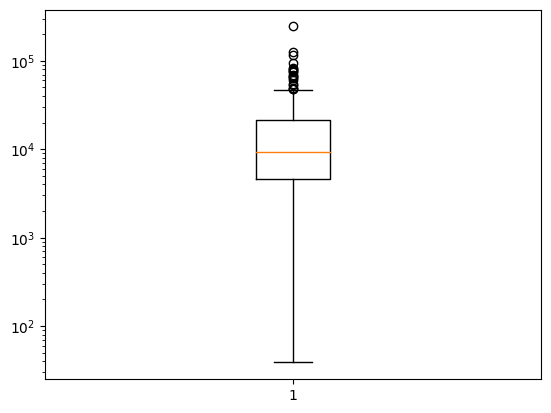

In [111]:
plt.boxplot(abs(y_test - preds))
plt.yscale('log')
plt.show()

# Test

In [114]:
models = [
    ('ridge', ridge_trans),
    ('rf', rf_trans),
    ('gb', gb.best_estimator_),
    ('lg_gb', lg_gb_trans),
    ('xgb', xgb_trans),
    ('stack', stck_trans)
]

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(name)
    print('Test MAE:', mean_absolute_error(y_test, y_pred).round(1))
    print('Test MedAE:', median_absolute_error(y_test, y_pred).round(1))
    print()

ridge
Test MAE: 19754.7
Test MedAE: 11591.8

rf
Test MAE: 20386.4
Test MedAE: 11603.5

gb
Test MAE: 17817.0
Test MedAE: 9637.3

lg_gb
Test MAE: 17820.1
Test MedAE: 10509.1

xgb
Test MAE: 17280.3
Test MedAE: 9938.2

stack
Test MAE: 17192.7
Test MedAE: 10078.1

